# <u>Deep L-layered Neural Network

### We will make a L -layers deep neural network for cat classification problem

This is a cat classification problem, where the task is to classify a picture as a cat or non-cat picture.
<br>Output y = 1 if the picture is of a cat 
<br>Output y = 0 if the picture is not of a cat

In [1]:
# import the libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py
import dataset_utility as du
%matplotlib inline

### Data loading and preprocessing work

The dataset contains cat and non-cat pictures and the labels are 0 or 1.<br>


In [2]:
# load the data set
test_loc = r'datasets\train_catvsnoncat.h5'
train_loc = r'datasets\test_catvsnoncat.h5'

train_X, train_y, test_X, test_y = du.load_data2(train_loc, test_loc)

print('Training features shape:'+ str(train_X.shape))
print('Training output shape:'+ str(train_y.shape))
print('Test features shape:'+ str(test_X.shape))
print('Test output shape:'+ str(test_y.shape))

Training features shape:(209, 64, 64, 3)
Training output shape:(209,)
Test features shape:(50, 64, 64, 3)
Test output shape:(50,)


### 1) <u>Reshape the matrices.</u>
### 2) <u>Flatten the feature matrix and create one hot matrix for output labels

In [3]:
# reshape the output matrices to avoid it being treated as rank 1 matrix
train_y = np.reshape(train_y, (train_y.shape[0],1))
test_y = np.reshape(test_y, (test_y.shape[0],1))

In [4]:
# noramalize the features
train_X, test_X = du.normalize_data( train_X, test_X)

# flatten the feature matrix
train_X, test_X = du.unroll_features(train_X, test_X)

# transpose the label matrices to match the dimension format
train_y = train_y.T
test_y = test_y.T

In [5]:
# check the dimensions
print('Training features shape:'+ str(train_X.shape))
print('Training output shape:'+ str(train_y.shape))
print('Test features shape:'+ str(test_X.shape))
print('Test output shape:'+ str(test_y.shape))

Training features shape:(12288, 209)
Training output shape:(1, 209)
Test features shape:(12288, 50)
Test output shape:(1, 50)


## <u>Neural Network Architecture
We will be using sigmoid activation function for the output layer and use a non-linear activation function like sigmoid, tanh, ReLU for the hidden layer units.
<br>For each hidden layer [l]: <br>Activation output from[l-1] ---> Z[l] ----> Activation function----->A[l] 

## <u>Helper Functions

### Initialize weight and bias parameters


In [6]:
def random_init_parameters(num_layers, n_layer):
    '''
    for initializing the weight and bias parameters with random values
    
    Arguments:
        num_layers: (int) no. of layers in the neural network
        n_layer: (list) no. of units in each layer
    Returns:
        parameters: (dict) zero initialized weight and bias parameters 
    '''
    parameters = {}
    
    for l in range(num_layers):
        parameters['W' + str(l+1)] = np.random.randn(n_layer[l+1], n_layer[l]) * 0.01
        parameters['b' + str(l+1)] = np.zeros((n_layer[l+1],1)) 
    
    return parameters

### Activation function

In [7]:
# for doing the sigmoid function
def sigmoid(z):
    '''
    for computing the sigmoid function
    
    Arguments:
        z: linear input
    Returns:
        A: (float) sigmoid output
    '''
    A = (1/ (1 + np.exp(-z)))
    return A

In [8]:
# for doing the ReLU function
def relu(z):
    '''
    for computing the relu function
    
    Arguments:
        z: linear input
    Returns:
        A: (float) relu output
    '''
    A = np.maximum(0, z)
    return A

In [9]:
def activation_func(Z, acti_func):
    '''
    for applying the activation function
    
    Arguments:
        z: (numpy matrix) linear input
        acti_func:(str) activation function name(choice)
    Returns:
        A: (float) non-linear activation output
    '''
    # apply the activation function based on the choice
    if acti_func == 'sigmoid':
        A = sigmoid(Z)
    elif acti_func == 'relu':
        A = relu(Z)
    elif acti_func == 'tanh':
        A = np.tanh(Z)
    else:
        A = relu(Z)
        
    return A

### Cost Function

In [10]:
# for computing the logistic error
def compute_cost(train_y, y_hat):
    '''
    for computing the mean loss (cost) for logistic regression
    
    Arguments:
        train_y:(numpy matrix) contains the correct output labels for m training examples
        y_hat:(numpy matrix) contains the sigmoid output values for m training examples
    Returns:
        cost: (float) cost value for m training examples
    '''
    cost = (1/train_y.shape[1]) * np.sum( -train_y*np.log(y_hat) - (1-train_y)*np.log(1 - y_hat) )
    
    # for avoiding 1 dimensional values 
    cost = np.squeeze(cost)
    return cost

In [58]:
def gradient_descent(parameters, grads, learning_rate, num_layers):
    '''
    for doing gradient descent and updating the weights
    
    Arguments:
        parameters: (dict) contains the learned weight and bias parameters
        grads:(dict) contains the gradients for different layers
        learning_rate: (float) learning rate
        num_layers:(int) no. of layers in the Neural network
    Returns:
        parameters: (dict) contains the learned weight and bias parameters
    '''
    # update the parameters
    for l in range(num_layers):
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - (learning_rate * grads['dW'+str(l+1)])
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - (learning_rate * grads['db'+str(l+1)])
   
    return parameters

In [59]:
def forward_propagation(features_X, parameters, num_layers, acti_fun):
    '''
    for doing forward propagation in neural network
    
    Arguments:
        features_X: (numpy matrix) features for all training examples
        parameters: (dict) contains the learned weight and bias parameters
        num_layers:(int) no. of layers in the Neural network
        acti_fun: (str) name of the activation function to use
    Returns:
        inter_val: (dict) contains the linear output Z and activation output A for each layer
    '''
    # for saving the computed intermediate values for each layer
    inter_val = {}
    
    # make activation for input layer equal to the features
    A = features_X
    inter_val['A0'] = A
    
    # do forward propagation for all hidden layers except for the output layer
    for l in range(num_layers-1):
        # first find the linear output for each layer
        inter_val['Z' + str(l+1)] = np.dot(parameters['W' + str(l+1)], A) + parameters['b' + str(l+1)]
        inter_val['A' + str(l+1)] = activation_func(inter_val['Z' + str(l+1)], acti_fun)
        A = inter_val['A'+str(l+1)]
        
    # forward propagation for output layer
    inter_val['Z' + str(num_layers)] = np.dot(parameters['W' + str(num_layers)], A) + parameters['b' + str(num_layers)]
    inter_val['A' + str(num_layers)] = activation_func(inter_val['Z' + str(num_layers)], 'sigmoid')
    
    return inter_val 

In [60]:
def activation_derivative(dA, Z, acti_func):
    '''
    for finding the derivative of linear output Z with a particular activation function in its layer
    
    Arguments:
        dA: (numpy matrix) partial derivative of loss function wrt activation outputs for the given layer  
        Z: (numpy matrix) contains the linear otuput for the given layer
        acti_fun: (str) name of the activation function to use
    Returns:
        dZ: (numpy matrix) partial derivative of loss function wrt linear output Z for the given layer
    '''
    # for sigmoid activation function
    if acti_func == 'sigmoid':
        s = sigmoid(Z)
        dZ = dA*s*(1-s)
        
    # for relu activation function
    elif acti_func == 'relu':
        dZ = np.copy(dA)
        dZ[Z<=0] = 0
        
    return dZ

In [61]:
def backward_propagate(train_X, train_y, parameters, inter_val, num_layers):
    '''
    for doing backward propagation in neural network
    
    Arguments:
        train_X: (numpy matrix) features for all training examples
        train_y: (numpy matrix) correct labels for all training examples
        parameters: (dict) contains the learned weight and bias parameters
        num_layers:(int) no. of layers in the Neural network
        inter_val: (dict) contains the linear output Z and activation output A for each layer
    Returns:
        grads: (dict) contains the gradients for different layers
    '''
    #no. of training examples
    m = train_X.shape[1]
    
    # for storing the gradients
    grads = {}
    
    # gradients for output layer
    AL = inter_val['A' + str(num_layers)]
    dA = -train_y/AL + (1-train_y)/(1-AL)
    dZ = activation_derivative(dA, inter_val['Z' + str(num_layers)], 'sigmoid')
    grads['dW'+str(num_layers)] = (1/m)*np.dot(dZ, inter_val['A'+str(num_layers-1)].T)
    grads['db'+str(num_layers)] = (1/m)*np.sum(dZ, axis = 1, keepdims = True)
    dA = np.dot(parameters['W'+str(num_layers)].T, dZ)
    
    for l in reversed(range(1,num_layers)):
        dZ = activation_derivative(dA, inter_val['Z' + str(l)], 'relu')
        grads['dW'+str(l)] = (1/m)*np.dot(dZ, inter_val['A'+str(l-1)].T)
        grads['db'+str(l)] = (1/m)*np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(parameters['W'+str(l)].T, dZ)
        
    return grads

In [69]:
def nn_model(train_X, train_y, num_layers, n_layer, num_iters, learning_rate):
    '''
    for training the model by doing steps systematically
    
    Arguments:
        train_X:(numpy matrix) contains the input features for m training examples
        train_y:(numpy matrix) contains the correct output labels for m training examples
        num_iters: (int) no. of iterations to run 
        learning_rate: (float) learning rate
     Returns:
        parameters: (dict) contains the learned weight and bias parameters
        costs: (list) contains cost per 100 iterations
    '''
    
    parameters = random_init_parameters(num_layers, n_layer)
    
    # for storing the costs
    costs = []
    for i in range(num_iters):
        # do forward propagation
        inter_val = forward_propagation(train_X, parameters, num_layers, 'relu')
        # compute the cost
        cost = compute_cost(train_y, inter_val['A'+str(num_layers)])
        # do backward propagation
        grads = backward_propagate(train_X, train_y, parameters, inter_val, num_layers)
        # update parameters
        parameters = gradient_descent(parameters, grads, learning_rate, num_layers)
        
        if i%100 == 0:
            print('Cost after iteration %i:%f'%(i,cost))
        costs.append(cost)    
    return parameters, costs

In [76]:
num_layers = 2
n_layer = [12288, 7, 1]
learning_rate = 0.0075
num_iters = 2500
parameters, costs = nn_model(train_X, train_y, num_layers, n_layer, num_iters, learning_rate)

Cost after iteration 0:0.693127
Cost after iteration 100:0.647598
Cost after iteration 200:0.634713
Cost after iteration 300:0.606501
Cost after iteration 400:0.563252
Cost after iteration 500:0.512054
Cost after iteration 600:0.451598
Cost after iteration 700:0.388893
Cost after iteration 800:0.363807
Cost after iteration 900:0.364767
Cost after iteration 1000:0.334600
Cost after iteration 1100:0.299498
Cost after iteration 1200:0.220528
Cost after iteration 1300:0.158900
Cost after iteration 1400:0.131092
Cost after iteration 1500:0.110172
Cost after iteration 1600:0.094221
Cost after iteration 1700:0.080147
Cost after iteration 1800:0.068123
Cost after iteration 1900:0.058971
Cost after iteration 2000:0.051670
Cost after iteration 2100:0.045665
Cost after iteration 2200:0.040592
Cost after iteration 2300:0.036457
Cost after iteration 2400:0.032860


In [71]:
def plot_learning_curve(costs, learning_rate):
    '''
    for plotting learning curve
    
    Arguments:
        costs: (list) contains the costs per 100 iterations
        learning_rate: (float) learning rate
    Returns:
        nil
    '''
    # Plot learning curve( cost vs iterations)
    costs = np.squeeze(costs)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

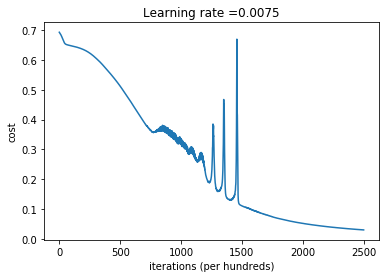

In [77]:
plot_learning_curve(costs, learning_rate)

In [73]:
def predict(features_X, parameters):
    '''
    for predicting the output labels for inputs
    
    Arguments:
        feature_X: (numpy matrix) contains the input features for m training examples
        parameters: (dict) contains the learned weight and bias parameters
    Returns:
        pred: (numpy array) output labels
    '''
    # find the output of logistic regression
    inter_val = forward_propagation(features_X, parameters, num_layers, 'relu')
    # take the sigmoid output
    pred = inter_val['A'+str(num_layers)]
    
    # if the output is >0.5 then we consider that the picture is of a cat else it is a non-cat picture. 
    pred = (pred > 0.5)
    
    return pred    

In [78]:
prediction_train = predict(train_X, parameters)
prediction_test = predict(test_X, parameters)

# Print train/test Errors
print("train accuracy: {} %".format(100 - np.mean(np.abs(prediction_train - train_y)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(prediction_test - test_y)) * 100))

train accuracy: 100.0 %
test accuracy: 70.0 %
